# Сбор и предварительная обработка датасета

In [1]:
import numpy as np
import pandas as pd
from torch.backends.mkl import verbose

## lmsys-chat-1m

In [2]:
df = pd.read_parquet('data/lmsys-chat-1m/train-00000-of-00006-4feeb3f83346a0e9.parquet')

df.head(10)

,conversation_id,model,conversation,turn,language,openai_moderation,redacted
0,33f01939a744455c869cb234afca47f1,wizardlm-13b,[{'content': 'how can identity protection serv...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
1,1e230e55efea4edab95db9cb87f6a9cb,vicuna-13b,[{'content': 'Beside OFAC's selective sanction...,6,English,"[{'categories': {'harassment': False, 'harassm...",False
2,0f623736051f4a48a506fd5933563cfd,vicuna-13b,[{'content': 'You are the text completion mode...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
3,e5c923a7fa3f4893beb432b4a06ef222,palm-2,[{'content': 'The sum of the perimeters of thr...,2,English,"[{'categories': {'harassment': False, 'harassm...",False
4,8ad66650dced4b728de1d14bb04657c1,vicuna-13b,[{'content': 'What is the type of the variable...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
5,aa041ed88edd4100bde61b8d68fc7288,wizardlm-13b,[{'content': 'I have 1000 documents to downloa...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
6,113d3ddd85874229a04a660bc629c2cc,vicuna-13b,"[{'content': 'summarise below transcript ""Stud...",1,English,"[{'categories': {'harassment': False, 'harassm...",False
7,4c95520511844ca492ad9ec1cb3672e3,llama-2-13b-chat,[{'content': 'Определи важнейшие смыслы в текс...,3,unknown,"[{'categories': {'harassment': False, 'harassm...",False
8,64f322dcb69d43229bbd9785b7d90f1b,vicuna-13b,"[{'content': 'Buenas noches!', 'role': 'user'}...",8,Spanish,"[{'categories': {'harassment': False, 'harassm...",False
9,6fc9a36392e94a83939dc3738ab9e245,vicuna-13b,[{'content': 'hola puedes hablar español de ar...,5,Spanish,"[{'categories': {'harassment': False, 'harassm...",False


### Возьмем только англоязычные сообщения

In [3]:
df.value_counts(df['language'])

language
English       129664
Portuguese      4821
Russian         4705
unknown         4585
Chinese         4121
               ...  
Tibetan            1
Tigrinya           1
Swati              1
Tamil              1
Yiddish            1
Name: count, Length: 142, dtype: int64

In [4]:
df = df[df['language'] == 'English']

df.head(10)

,conversation_id,model,conversation,turn,language,openai_moderation,redacted
0,33f01939a744455c869cb234afca47f1,wizardlm-13b,[{'content': 'how can identity protection serv...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
1,1e230e55efea4edab95db9cb87f6a9cb,vicuna-13b,[{'content': 'Beside OFAC's selective sanction...,6,English,"[{'categories': {'harassment': False, 'harassm...",False
2,0f623736051f4a48a506fd5933563cfd,vicuna-13b,[{'content': 'You are the text completion mode...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
3,e5c923a7fa3f4893beb432b4a06ef222,palm-2,[{'content': 'The sum of the perimeters of thr...,2,English,"[{'categories': {'harassment': False, 'harassm...",False
4,8ad66650dced4b728de1d14bb04657c1,vicuna-13b,[{'content': 'What is the type of the variable...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
5,aa041ed88edd4100bde61b8d68fc7288,wizardlm-13b,[{'content': 'I have 1000 documents to downloa...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
6,113d3ddd85874229a04a660bc629c2cc,vicuna-13b,"[{'content': 'summarise below transcript ""Stud...",1,English,"[{'categories': {'harassment': False, 'harassm...",False
10,2d9631f925044e47abcc147e64a0268e,vicuna-13b,[{'content': 'Please focus on preparing for th...,1,English,"[{'categories': {'harassment': False, 'harassm...",True
11,7f4abf64593c439f8b085585aeeda566,koala-13b,[{'content': 'Give me an introduction over 200...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
13,e3addcd33c9d42b2be07c4bbbf9ce92e,llama-2-13b-chat,[{'content': 'how many floors does the burj al...,6,English,"[{'categories': {'harassment': False, 'harassm...",True


### Уберем ненужные колонки

In [5]:
df.drop(['conversation_id', 'model', 'openai_moderation', 'redacted', 'language', 'turn'], inplace=True, axis=1)
df.head(10)

,conversation
0,[{'content': 'how can identity protection serv...
1,[{'content': 'Beside OFAC's selective sanction...
2,[{'content': 'You are the text completion mode...
3,[{'content': 'The sum of the perimeters of thr...
4,[{'content': 'What is the type of the variable...
5,[{'content': 'I have 1000 documents to downloa...
6,"[{'content': 'summarise below transcript ""Stud..."
10,[{'content': 'Please focus on preparing for th...
11,[{'content': 'Give me an introduction over 200...
13,[{'content': 'how many floors does the burj al...


### Сбор нового датасета по пользователям

In [6]:
new_rows = []

for user_id, convo in enumerate(df['conversation']):
    previous_model_message = None
    for msg in convo:
        if msg['role'] == 'user':
            new_rows.append({
                'user_id': user_id,
                'user_message': msg['content'],
                'previous_model_message': previous_model_message
            })
        elif msg['role'] == 'assistant':
            previous_model_message = msg['content']

new_df = pd.DataFrame(new_rows)
new_df.to_csv('data/lmsys-chat-1m/processed/dialogs.csv', index=False)
new_df.head(10)

,user_id,user_message,previous_model_message
0,0,how can identity protection services help prot...,None
1,1,Beside OFAC's selective sanction that target t...,None
2,1,are there other types of US sanctions that you...,The United States has a number of different ty...
3,1,please make organized conclusion in bullet lis...,"Yes, there are several other types of US sanct..."
4,1,"can you please revise the answer above again, ...",* Selective sanctions: targeted at specific in...
5,1,if you see a person name stating that it is th...,"Sure, here is a revised list of the different ..."
6,1,if you see a person's name stating that it is ...,
7,2,You are the text completion model and you must...,None
8,3,The sum of the perimeters of three equal squar...,None
9,3,ty,The perimeter of one square is 36 / 3 = 12 cm....


### Проверка на полноту и целостность

In [7]:
df = pd.read_csv("data/lmsys-chat-1m/processed/dialogs.csv")

print("Пропущенные значения:")
print(df.isnull().sum())

print(f"Уникальных пользователей: {df['user_id'].nunique()}")

empty_user_messages = df[df['user_message'].str.strip().eq('') | df['user_message'].isnull()]
print(f"Пустых или отсутствующих user_message: {len(empty_user_messages)}")

no_previous_model_msg = df['previous_model_message'].isnull().sum()
print(f"Сообщений без previous_model_message (начало диалога): {no_previous_model_msg}")

user_message_count = df['user_message'].notnull().sum()
print(f"Всего сообщений от пользователя: {user_message_count}")

model_message_count = df['previous_model_message'].notnull().sum()
print(f"Всего сообщений от модели (предыдущих): {model_message_count}")

Пропущенные значения:
user_id                        0
user_message                   0
previous_model_message    130831
dtype: int64
Уникальных пользователей: 129664
Пустых или отсутствующих user_message: 16
Сообщений без previous_model_message (начало диалога): 130831
Всего сообщений от пользователя: 250310
Всего сообщений от модели (предыдущих): 119479


### Выбор и извлечение признаков

**Цель:** Создать информативные признаки, которые могут описать поведение пользователей и эмоциональные оттенки (паралингвистические признаки и другие).

**Категории признаков:**

#### А) Паралингвистические признаки:

- **Использование пунктуации:**
  - Частота восклицательных и вопросительных знаков.
  - Многоточия («...»).

- **Использование эмодзи и символов:**
  - Признаки наличия/отсутствия и количества эмодзи.

- **Длина:**
  - Длина сообщений (количество слов).

- **Стилистические особенности:**
  - Использование заглавных букв (например, сообщения капсом).
  - Повтор слов и переформулировки.
  - Орфографические ошибки (их количество и регулярность).

#### Б) Лингвистические и семантические признаки:

- Сентимент-анализ (позитив, негатив, нейтральность).

#### В) Диалоговые признаки (контекст взаимодействия):

- Количество взаимодействий до завершения диалога.
- Переключение тем или возвращение к ранее обсуждаемой теме (анализ расстояния между векторами сообщений).

### Подсчет количества слов в сообщениях

In [8]:
def count_words(text):
    if pd.isnull(text):
        return 0
    return len(text.strip().split())

df['word_count'] = df['user_message'].apply(count_words)

df_total_words = (
    df.groupby('user_id')['word_count']
      .sum()
      .reset_index()
      .rename(columns={'word_count': 'total_words'})
)

df_total_words.head(10)


,user_id,total_words
0,0,11
1,1,150
2,2,66
3,3,29
4,4,18
5,5,46
6,6,182
7,7,111
8,8,25
9,9,59


### Подсчет количества восклицательных и вопросительных знаков

In [9]:
df['exclamation_count'] = df['user_message'].fillna('').apply(lambda x: x.count('!'))

df['question_count'] = df['user_message'].fillna('').apply(lambda x: x.count('?'))

df_punct_totals = df.groupby('user_id')[['exclamation_count', 'question_count']].sum().reset_index()
df_punct_totals = df_punct_totals.rename(columns={
    'exclamation_count': 'total_exclamations',
    'question_count': 'total_questions'
})

df_punct_totals.head(10)

,user_id,total_exclamations,total_questions
0,0,0,0
1,1,0,4
2,2,0,0
3,3,0,0
4,4,0,0
5,5,0,2
6,6,0,4
7,7,0,3
8,8,0,0
9,9,0,0


### Подсчет многоточий (.. и ...)

In [10]:
import re

def count_ellipsis(text):
    if pd.isnull(text):
        return 0
    # Находим все вхождения из двух или более точек подряд
    return len(re.findall(r'\.{2,}', text))

df['ellipsis_count'] = df['user_message'].apply(count_ellipsis)

df_ellipsis = df.groupby('user_id')['ellipsis_count'].sum().reset_index()
df_ellipsis = df_ellipsis.rename(columns={'ellipsis_count': 'total_ellipses'})

df_ellipsis.head(10)


,user_id,total_ellipses
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


### Подсчет использования эмодзи

In [11]:
# pip install emoji

import emoji
import re

# типичные текстовые смайлики
text_smileys = [
    r":\)", r":D", r";\)", r":\(", r":P", r":3", r":O", r":'\(", r":'\)", r":-D", r"o_O", r"O_o",
    r":-P", r":-/", r":-\\", r":\|", r":-X", r"<3", r":-S", r":-@", r":\^\)", r"\^_\^", r"-_-", r"XD"
]

smileys_pattern = re.compile("|".join(text_smileys))

# Функция для подсчёта всех эмодзи и смайликов
def count_all_faces(text):
    if pd.isnull(text):
        return 0
    emoji_count = sum(1 for char in text if char in emoji.EMOJI_DATA)
    smiley_count = len(smileys_pattern.findall(text))
    return emoji_count + smiley_count

df['paraling_face_count'] = df['user_message'].apply(count_all_faces)

df_faces = df.groupby('user_id')['paraling_face_count'].sum().reset_index()
df_faces = df_faces.rename(columns={'paraling_face_count': 'total_paraling_faces'})

df_faces.head(10)


,user_id,total_paraling_faces
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


### Подсчет слов, которые были полностью написаны капсом

In [12]:
# подсчёт слов, написанных полностью капсом
def count_all_caps_words(text):
    if pd.isnull(text):
        return 0
    # Делим на слова
    return sum(1 for word in text.split() if word.isalpha() and word.isupper() and len(word) > 1)

df['caps_word_count'] = df['user_message'].apply(count_all_caps_words)

df_caps = df.groupby('user_id')['caps_word_count'].sum().reset_index()
df_caps = df_caps.rename(columns={'caps_word_count': 'total_caps_words'})

df_caps.head(10)

,user_id,total_caps_words
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,1
9,9,0


### Подсчет повтора слов

In [13]:
from collections import Counter
import re

def count_repeated_words(text):
    if pd.isnull(text):
        return 0
    words = re.findall(r'\b\w+\b', text.lower())
    word_counts = Counter(words)
    repeated = [word for word, count in word_counts.items() if count > 1]
    return len(repeated)

df['repeated_word_count'] = df['user_message'].apply(count_repeated_words)

df_repeats = df.groupby('user_id')['repeated_word_count'].sum().reset_index()
df_repeats = df_repeats.rename(columns={'repeated_word_count': 'total_repeated_words'})

df_repeats.head(10)


,user_id,total_repeated_words
0,0,1
1,1,18
2,2,16
3,3,3
4,4,2
5,5,6
6,6,38
7,7,14
8,8,2
9,9,4


### Подсчет переформулировок

In [14]:
import torch

from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используется устройство: {device}")

# Загружаем предобученную модель для эмбеддингов предложений
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',  device=device)

# подсчёт переформулировок у одного пользователя
def count_reformulations(messages):
    messages = [msg for msg in messages if isinstance(msg, str) and msg.strip()]
    if len(messages) < 2:
        return 0
    # Получаем эмбеддинги сообщений
    embeddings = model.encode(messages, convert_to_tensor=False, device=device)
    sims = cosine_similarity(embeddings[:-1], embeddings[1:])
    # Считаем количество "похожих, но не идентичных" сообщений
    count = sum(1 for sim in sims.diagonal() if 0.8 <= sim < 0.99) # s < 0.8 - непохожие, s > 0.99 - копи паста
    return count

results = []
for user_id, group in tqdm(df.groupby('user_id'), desc="Processing users"):
    messages = group['user_message'].tolist()
    reform_count = count_reformulations(messages)
    results.append({'user_id': user_id, 'total_reformulations': reform_count})

df_reform = pd.DataFrame(results)

df_reform.head(10)

C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Используется устройство: cuda


Processing users: 100%|██████████| 129664/129664 [06:43<00:00, 321.47it/s]


,user_id,total_reformulations
0,0,0
1,1,3
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


### Подсчет орфографических ошибок

In [15]:
# pip install pyspellchecker

from spellchecker import SpellChecker
import re

spell = SpellChecker()

# подсчёт орфографических ошибок в одном сообщении
def count_spelling_errors(text):
    if pd.isnull(text):
        return 0
    # Приводим к нижнему регистру и выделяем слова
    words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    misspelled = spell.unknown(words)
    return len(misspelled)

df['spelling_error_count'] = df['user_message'].apply(count_spelling_errors)

df_spell_errors = df.groupby('user_id')['spelling_error_count'].sum().reset_index()
df_spell_errors = df_spell_errors.rename(columns={'spelling_error_count': 'total_spelling_errors'})

df_spell_errors.head(10)


,user_id,total_spelling_errors
0,0,0
1,1,3
2,2,0
3,3,0
4,4,3
5,5,0
6,6,3
7,7,0
8,8,2
9,9,3


### Сентиментальный анализ

In [16]:
# pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    if pd.isnull(text) or not text.strip():
        return 'neutral'  # пустые = нейтральные
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['user_message'].apply(classify_sentiment)

df_sentiment_counts = (
    df.groupby(['user_id', 'sentiment'])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)

df_sentiment_counts = df_sentiment_counts.rename(columns={
    'positive': 'positive_count',
    'negative': 'negative_count',
    'neutral': 'neutral_count'
})

df_sentiment_counts.columns.name = None
df_sentiment_counts.head(10)


,user_id,negative_count,neutral_count,positive_count
0,0,0,0,1
1,1,1,2,3
2,2,0,0,1
3,3,0,1,1
4,4,0,1,0
5,5,0,0,1
6,6,0,0,1
7,7,0,0,1
8,8,1,0,0
9,9,0,6,0


### Количество взаимодействий (сообщений пользователя)

In [17]:
df_message_counts = (
    df.groupby('user_id')
      .size()
      .reset_index(name='total_user_messages')
)

df_message_counts.head(10)

,user_id,total_user_messages
0,0,1
1,1,6
2,2,1
3,3,2
4,4,1
5,5,1
6,6,1
7,7,1
8,8,1
9,9,6


### Сбор финального датасета feature

In [18]:
# Словарь всех признаков по user_id
feature_dfs = {
    'total_words': df_total_words,                     # общее число слов в диалоге
    'punctuation': df_punct_totals,                    # ! и ? всего
    'ellipses': df_ellipsis,                           # многоточия
    'emojis_smileys': df_faces,                        # эмодзи + смайлики
    'caps_words': df_caps,                             # капс-слова
    'word_repeats': df_repeats,                        # повторы слов
    'reformulations': df_reform,                       # переформулировки
    'spelling_errors': df_spell_errors,                # орфографические ошибки
    'sentiment': df_sentiment_counts,                  # позитив / негатив / нейтрально
    'messages_count': df_message_counts,               # кол-во взаимодействий
}

# признаки, которые включаем в итоговый датасет
include = [
    'total_words',
    'punctuation',
    'ellipses',
    'emojis_smileys',
    'caps_words',
    'word_repeats',
    'reformulations',
    'spelling_errors',
    'sentiment',
    'messages_count'
]

df_features = None
df_len = None
for name, df_part in feature_dfs.items():
    if name in include:
        if df_features is None:
            df_features = df_part.copy()
            df_len = len(df_part)
        else:
            assert df_len == len(df_part), f'{name} dataset has a different number of rows compared to the others'
            df_features = df_features.merge(df_part, on='user_id', how='left')

df_features.to_csv('data/lmsys-chat-1m/processed/features.csv')
df_features.head(10)

,user_id,total_words,total_exclamations,total_questions,total_ellipses,total_paraling_faces,total_caps_words,total_repeated_words,total_reformulations,total_spelling_errors,negative_count,neutral_count,positive_count,total_user_messages
0,0,11,0,0,0,0,0,1,0,0,0,0,1,1
1,1,150,0,4,0,0,1,18,3,3,1,2,3,6
2,2,66,0,0,0,0,0,16,0,0,0,0,1,1
3,3,29,0,0,0,0,0,3,0,0,0,1,1,2
4,4,18,0,0,0,0,0,2,0,3,0,1,0,1
5,5,46,0,2,0,0,0,6,0,0,0,0,1,1
6,6,182,0,4,0,0,0,38,0,3,0,0,1,1
7,7,111,0,3,0,0,0,14,0,0,0,0,1,1
8,8,25,0,0,0,0,1,2,0,2,1,0,0,1
9,9,59,0,0,0,0,0,4,0,3,0,6,0,6


### Создадим нормализованный по количеству сообщений датасет

In [19]:
# Копируем только нужные числовые колонки (кроме user_id и total_messages)
columns_to_normalize = [
    col for col in df_features.columns
    if col not in ['user_id', 'total_user_messages']
    and pd.api.types.is_numeric_dtype(df_features[col])
]

# Нормализуем, сохраняя оригинальные названия колонок
df_normalized = df_features[['user_id']].copy()
for col in columns_to_normalize:
    df_normalized[col] = df_features[col] / df_features['total_user_messages']

df_normalized.to_csv('data/lmsys-chat-1m/processed/features_normalized.csv')
df_normalized.head(10)

,user_id,total_words,total_exclamations,total_questions,total_ellipses,total_paraling_faces,total_caps_words,total_repeated_words,total_reformulations,total_spelling_errors,negative_count,neutral_count,positive_count
0,0,11.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,1.0
1,1,25.000000,0.0,0.666667,0.0,0.0,0.166667,3.000000,0.5,0.5,0.166667,0.333333,0.5
2,2,66.000000,0.0,0.000000,0.0,0.0,0.000000,16.000000,0.0,0.0,0.000000,0.000000,1.0
3,3,14.500000,0.0,0.000000,0.0,0.0,0.000000,1.500000,0.0,0.0,0.000000,0.500000,0.5
4,4,18.000000,0.0,0.000000,0.0,0.0,0.000000,2.000000,0.0,3.0,0.000000,1.000000,0.0
5,5,46.000000,0.0,2.000000,0.0,0.0,0.000000,6.000000,0.0,0.0,0.000000,0.000000,1.0
6,6,182.000000,0.0,4.000000,0.0,0.0,0.000000,38.000000,0.0,3.0,0.000000,0.000000,1.0
7,7,111.000000,0.0,3.000000,0.0,0.0,0.000000,14.000000,0.0,0.0,0.000000,0.000000,1.0
8,8,25.000000,0.0,0.000000,0.0,0.0,1.000000,2.000000,0.0,2.0,1.000000,0.000000,0.0
9,9,9.833333,0.0,0.000000,0.0,0.0,0.000000,0.666667,0.0,0.5,0.000000,1.000000,0.0


## Нормализованный датасет

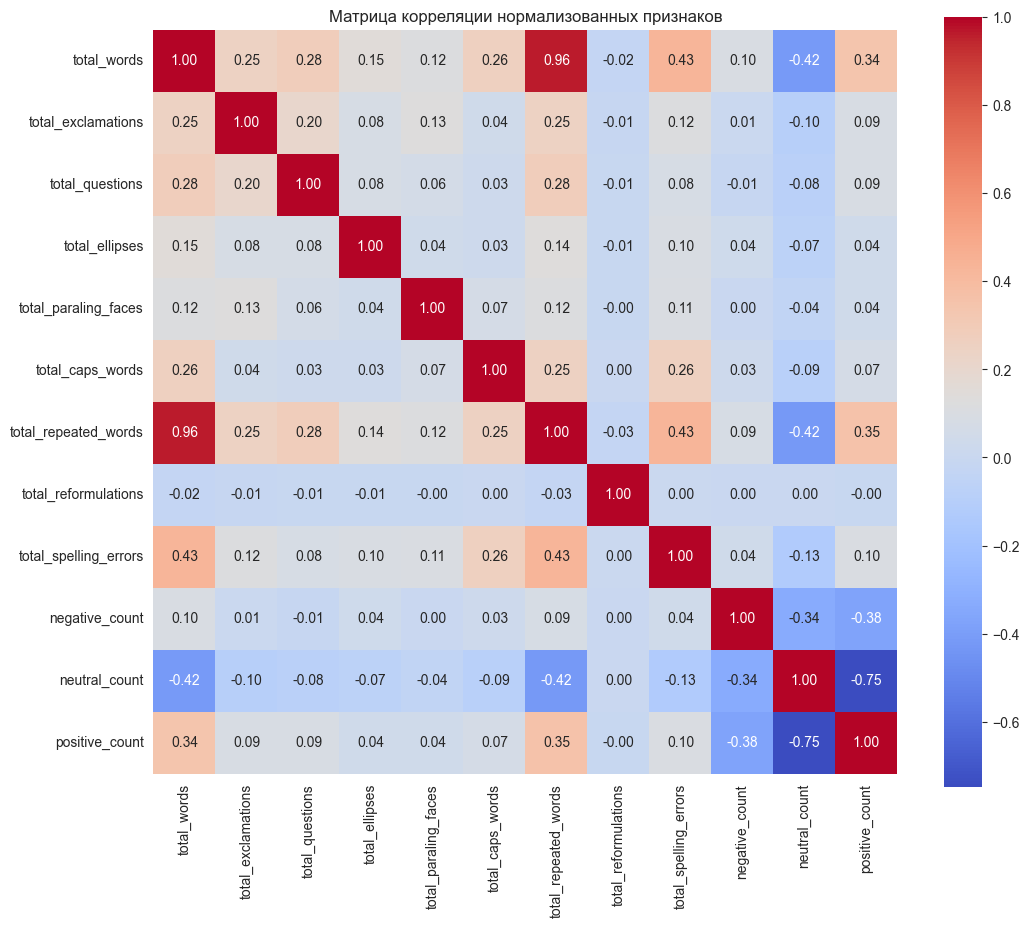

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [
    col for col in df_normalized.columns
    if col != 'user_id' and pd.api.types.is_numeric_dtype(df_normalized[col])
]

# Строим матрицу корреляции
corr_matrix = df_normalized[numeric_cols].corr()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Матрица корреляции нормализованных признаков")
plt.show()


#### Уберем признаки с сильной корреляцией

In [21]:
df_normalized.drop(['total_repeated_words'], inplace=True, axis=1)
# df_normalized.drop(['neutral_count'], inplace=True, axis=1)


### KMeans

#### Подготовка данных

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

X = df_normalized.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Находим оптимальное число кластеров по методу локтя

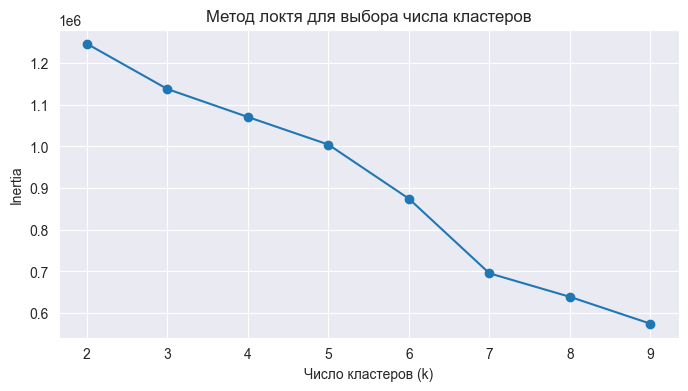

In [53]:
inertia = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title("Метод локтя для выбора числа кластеров")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

#### Обучение модели для k=5

In [24]:
k = 5

kmeans_5 = KMeans(n_clusters=k, random_state=42, verbose=True)
kmeans_labels_5 = kmeans_5.fit_predict(X_scaled)

df_kmeans_clusters_5 = df_normalized[['user_id']].copy()
df_kmeans_clusters_5['kmeans_cluster'] = kmeans_labels_5

sil_score = silhouette_score(X_scaled, df_kmeans_clusters_5['kmeans_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")


Initialization complete
Iteration 0, inertia 1188145.8119739091.
Iteration 1, inertia 1018560.028568177.
Iteration 2, inertia 1012443.2984989176.
Iteration 3, inertia 1008400.0879921308.
Iteration 4, inertia 1006605.1002526139.
Iteration 5, inertia 1005433.6375367963.
Iteration 6, inertia 1004967.5035490375.
Iteration 7, inertia 1004791.033073159.
Iteration 8, inertia 1004672.4992127.
Iteration 9, inertia 1004583.4021142981.
Iteration 10, inertia 1004546.4200784172.
Iteration 11, inertia 1004537.3743728945.
Iteration 12, inertia 1004536.0602741733.
Converged at iteration 12: strict convergence.
Silhouette Score: 0.445


#### Обучение модели для k=6


In [25]:
k = 6

kmeans_6 = KMeans(n_clusters=k, random_state=42, verbose=True)
kmeans_labels_6 = kmeans_6.fit_predict(X_scaled)

df_kmeans_clusters_6 = df_normalized[['user_id']].copy()
df_kmeans_clusters_6['kmeans_cluster'] = kmeans_labels_6

sil_score = silhouette_score(X_scaled, df_kmeans_clusters_6['kmeans_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

Initialization complete
Iteration 0, inertia 1044978.4876872061.
Iteration 1, inertia 887610.0329359464.
Iteration 2, inertia 882091.9168587861.
Iteration 3, inertia 878283.6451372403.
Iteration 4, inertia 876655.4570978464.
Iteration 5, inertia 875568.620825568.
Iteration 6, inertia 875070.9713806362.
Iteration 7, inertia 874926.1590305709.
Iteration 8, inertia 874769.1556183179.
Iteration 9, inertia 874719.5255899746.
Iteration 10, inertia 874672.8063054149.
Iteration 11, inertia 874644.4133105611.
Iteration 12, inertia 874639.9865294291.
Iteration 13, inertia 874639.0850365795.
Converged at iteration 13: center shift 2.9084678845259716e-07 within tolerance 9.999999999996584e-05.
Silhouette Score: 0.407


#### Обучение модели для k=7

In [26]:
k = 7

kmeans_7 = KMeans(n_clusters=k, random_state=42, verbose=True)
kmeans_labels_7 = kmeans_7.fit_predict(X_scaled)

df_kmeans_clusters_7 = df_normalized[['user_id']].copy()
df_kmeans_clusters_7['kmeans_cluster'] = kmeans_labels_7

sil_score = silhouette_score(X_scaled, df_kmeans_clusters_7['kmeans_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

Initialization complete
Iteration 0, inertia 809944.4755701289.
Iteration 1, inertia 708961.7994063977.
Iteration 2, inertia 705086.909135104.
Iteration 3, inertia 701843.5550057063.
Iteration 4, inertia 699928.1081079998.
Iteration 5, inertia 698929.0003952683.
Iteration 6, inertia 698313.353612916.
Iteration 7, inertia 697987.5086400902.
Iteration 8, inertia 697685.25316002.
Iteration 9, inertia 697457.120820212.
Iteration 10, inertia 697362.33001401.
Iteration 11, inertia 697333.2912361281.
Iteration 12, inertia 697306.6603528621.
Iteration 13, inertia 697254.8698536137.
Iteration 14, inertia 697068.9506535789.
Iteration 15, inertia 696873.6224243448.
Iteration 16, inertia 696510.0648674229.
Iteration 17, inertia 696212.9946061971.
Iteration 18, inertia 696130.1361196002.
Iteration 19, inertia 695766.8858609763.
Iteration 20, inertia 695608.719973758.
Iteration 21, inertia 695573.5275615884.
Converged at iteration 21: center shift 7.785071892912838e-05 within tolerance 9.99999999999

#### Визуализация для k=5

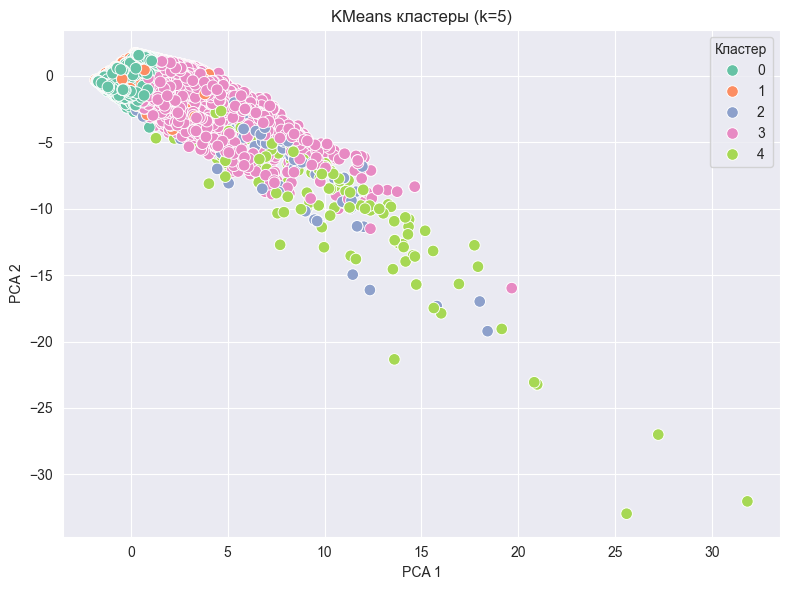

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_kmeans_vis_5 = df_kmeans_clusters_5.copy()
df_kmeans_vis_5['pca1'] = X_pca[:, 0]
df_kmeans_vis_5['pca2'] = X_pca[:, 1]

# Визуализация
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_kmeans_vis_5,
    x='pca1',
    y='pca2',
    hue='kmeans_cluster',
    palette='Set2',
    s=70
)
plt.title(f"KMeans кластеры (k=5)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Визуализация для k=6

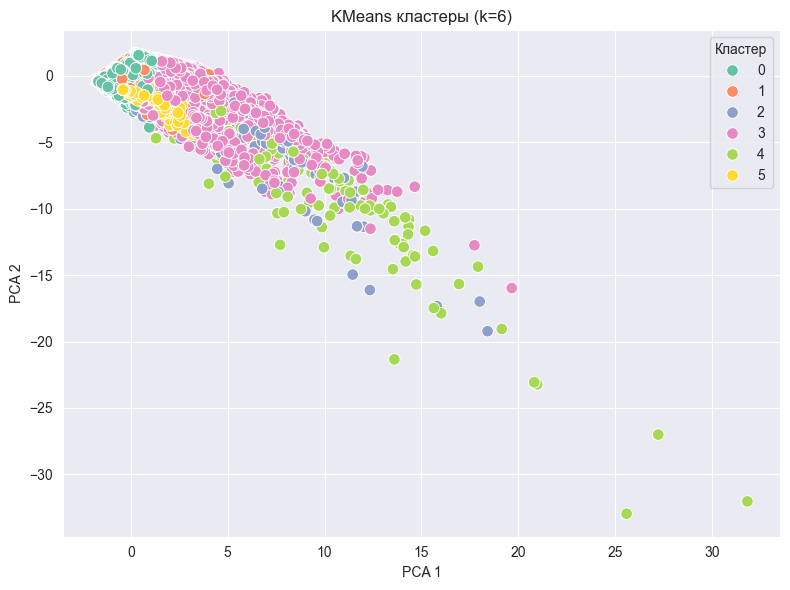

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_kmeans_vis_6 = df_kmeans_clusters_6.copy()
df_kmeans_vis_6['pca1'] = X_pca[:, 0]
df_kmeans_vis_6['pca2'] = X_pca[:, 1]

# Визуализация
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_kmeans_vis_6,
    x='pca1',
    y='pca2',
    hue='kmeans_cluster',
    palette='Set2',
    s=70
)
plt.title(f"KMeans кластеры (k=6)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Визуализация для k=7

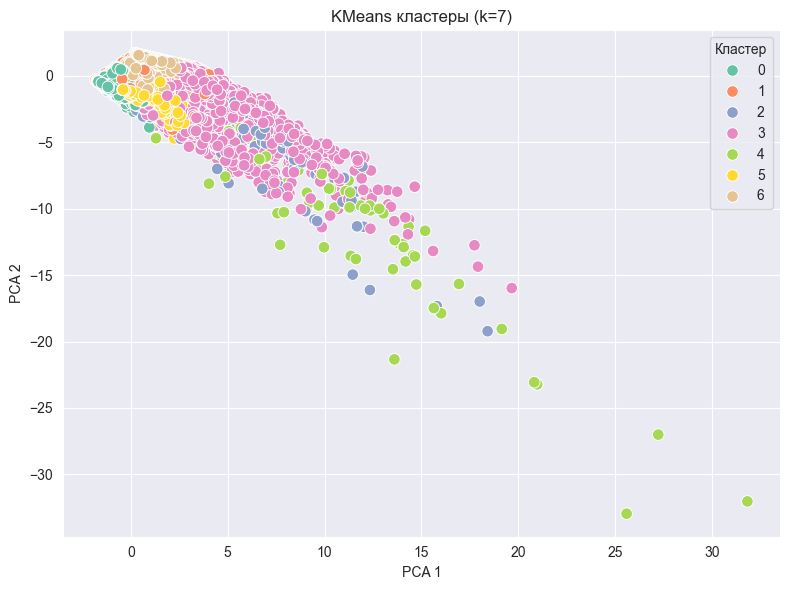

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_kmeans_vis_7 = df_kmeans_clusters_7.copy()
df_kmeans_vis_7['pca1'] = X_pca[:, 0]
df_kmeans_vis_7['pca2'] = X_pca[:, 1]

# Визуализация
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_kmeans_vis_7,
    x='pca1',
    y='pca2',
    hue='kmeans_cluster',
    palette='Set2',
    s=70
)
plt.title(f"KMeans кластеры (k=7)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


### Иерархическая кластеризация

#### Подготовка данных

In [30]:
from sklearn.preprocessing import StandardScaler

X = df_normalized.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Построение дендрограммы (для выбора k)

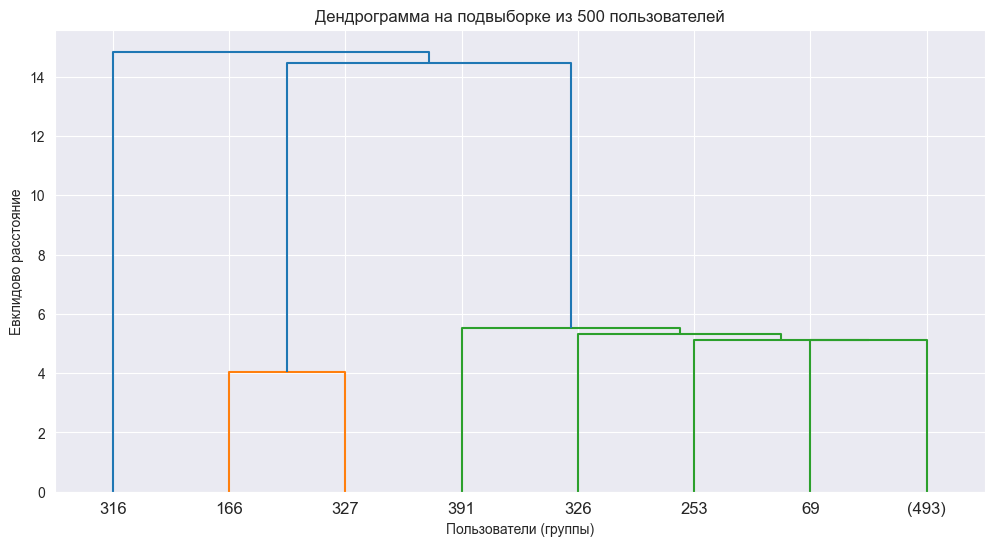

In [31]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

sample_size = 500  # иначе oom
X_sampled = X_scaled[np.random.choice(len(X_scaled), sample_size, replace=False)]

# linkage и дендрограмма
linked = linkage(X_sampled, method='single')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title(f"Дендрограмма на подвыборке из {sample_size} пользователей")
plt.xlabel("Пользователи (группы)")
plt.ylabel("Евклидово расстояние")
plt.grid(True)
plt.show()


#### Кластеризация с k=5

In [32]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 5

agglo_5 = AgglomerativeClustering(n_clusters=n_clusters, linkage='single')
agglo_labels_5 = agglo_5.fit_predict(X_scaled)

df_agglo_clusters_5 = df_normalized[['user_id']].copy()
df_agglo_clusters_5['agglo_cluster'] = agglo_labels_5

sil_score = silhouette_score(X_scaled, df_agglo_clusters_5['agglo_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.931


In [33]:
df_agglo_clusters_5['agglo_cluster'].value_counts()

agglo_cluster
0    129659
2         2
4         1
3         1
1         1
Name: count, dtype: int64

#### Кластеризация с k=6

In [34]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 6

agglo_6 = AgglomerativeClustering(n_clusters=n_clusters, linkage='single')
agglo_labels_6 = agglo_6.fit_predict(X_scaled)

df_agglo_clusters_6 = df_normalized[['user_id']].copy()
df_agglo_clusters_6['agglo_cluster'] = agglo_labels_6

sil_score = silhouette_score(X_scaled, df_agglo_clusters_6['agglo_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.928


In [35]:
df_agglo_clusters_6['agglo_cluster'].value_counts()

agglo_cluster
0    129658
2         2
4         1
3         1
1         1
5         1
Name: count, dtype: int64

#### Визуализация с k=5

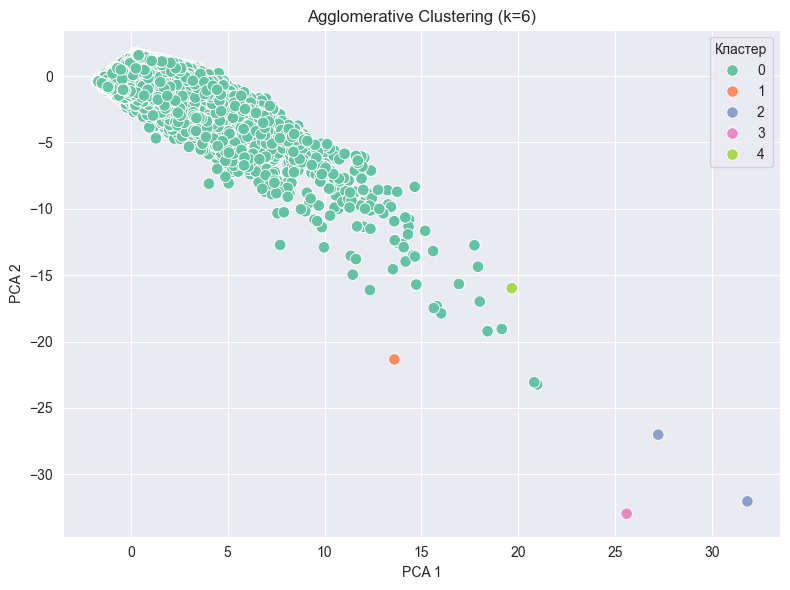

In [36]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализационный df
df_agglo_vis_5 = df_agglo_clusters_5.copy()
df_agglo_vis_5['pca1'] = X_pca[:, 0]
df_agglo_vis_5['pca2'] = X_pca[:, 1]

# Рисуем
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_agglo_vis_5,
    x='pca1',
    y='pca2',
    hue='agglo_cluster',
    palette='Set2',
    s=70
)
plt.title(f"Agglomerative Clustering (k={n_clusters})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Визуализация с k=6

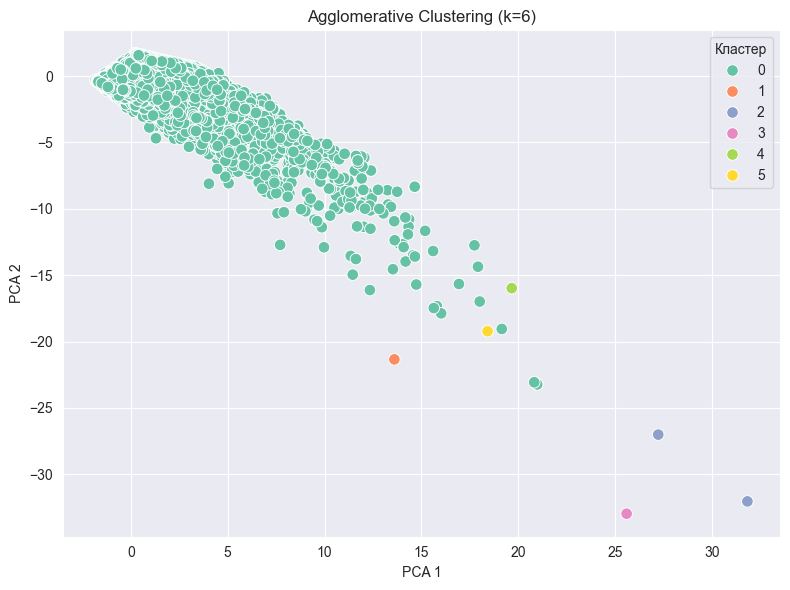

In [37]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализационный df
df_agglo_vis_6 = df_agglo_clusters_6.copy()
df_agglo_vis_6['pca1'] = X_pca[:, 0]
df_agglo_vis_6['pca2'] = X_pca[:, 1]

# Рисуем
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_agglo_vis_6,
    x='pca1',
    y='pca2',
    hue='agglo_cluster',
    palette='Set2',
    s=70
)
plt.title(f"Agglomerative Clustering (k={n_clusters})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


### DBSCAN

#### Подготовка данных

In [38]:
from sklearn.preprocessing import StandardScaler

X = df_normalized.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### Подбор значений

Подбор min_samples: 100%|██████████| 4/4 [04:15<00:00, 63.80s/it]


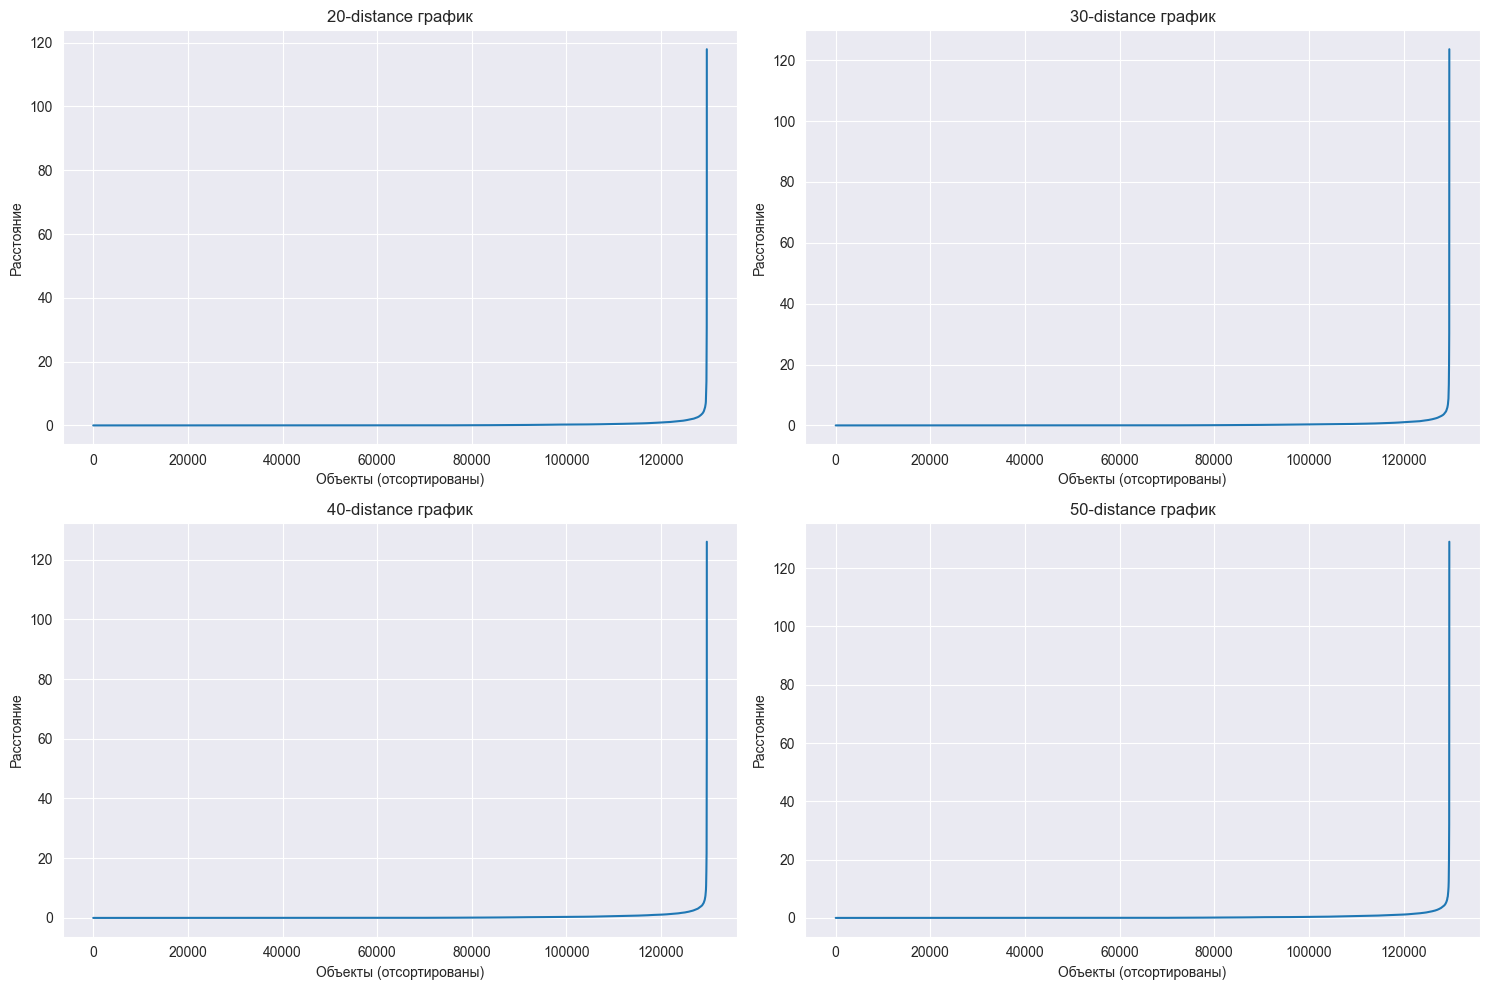

In [39]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

min_samples_list = [20, 30, 40, 50]

plt.figure(figsize=(15, 10))

for i, min_samples in enumerate(tqdm(min_samples_list, desc="Подбор min_samples"), 1):
    nn = NearestNeighbors(n_neighbors=min_samples)
    nn.fit(X_scaled)
    distances, _ = nn.kneighbors(X_scaled)

    k_distances = np.sort(distances[:, -1])

    plt.subplot(2, 2, i)
    plt.plot(k_distances)
    plt.title(f"{min_samples}-distance график")
    plt.xlabel("Объекты (отсортированы)")
    plt.ylabel("Расстояние")
    plt.grid(True)

plt.tight_layout()
plt.show()



#### Обучение DBSCAN

In [40]:
from sklearn.cluster import DBSCAN
import numpy as np

# Подвыборка
sample_size = 30000
idx_sample = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sampled = X_scaled[idx_sample]

# Обучаем DBSCAN на подвыборке
dbscan = DBSCAN(eps=13.0, min_samples=30)
dbscan_labels = dbscan.fit_predict(X_sampled)

# Собираем кластерный датафрейм для этой подвыборки
df_dbscan_clusters_sampled = df_normalized.iloc[idx_sample][['user_id']].copy()
df_dbscan_clusters_sampled['dbscan_cluster'] = dbscan_labels


#### Анализ кластеров

In [41]:
print(df_dbscan_clusters_sampled['dbscan_cluster'].value_counts())

dbscan_cluster
 0    29979
-1       21
Name: count, dtype: int64


#### Визуализация

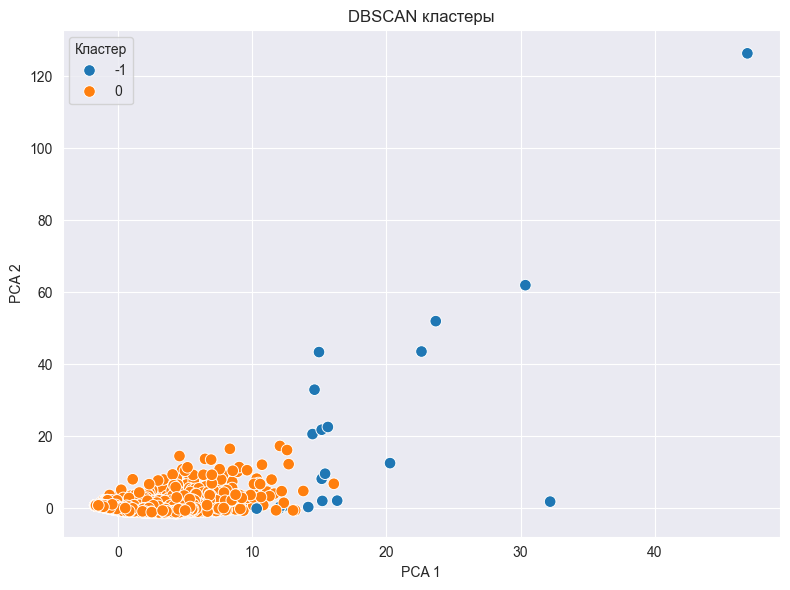

In [42]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

# Собираем визуализационный df
df_dbscan_vis = df_dbscan_clusters_sampled.copy()
df_dbscan_vis['pca1'] = X_pca[:, 0]
df_dbscan_vis['pca2'] = X_pca[:, 1]

# Отображаем
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_dbscan_vis,
    x='pca1',
    y='pca2',
    hue='dbscan_cluster',
    palette='tab10',
    s=70
)
plt.title("DBSCAN кластеры")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Силуэт оценка DBSCAN

In [43]:
from sklearn.metrics import silhouette_score

# Отфильтруем шум
mask_core = dbscan_labels != -1
X_core = X_sampled[mask_core]
labels_core = dbscan_labels[mask_core]

n_clusters = len(set(labels_core))
if n_clusters >= 2:
    sil_score = silhouette_score(X_core, labels_core)
    print(f"Silhouette Score (DBSCAN): {sil_score:.3f}")
else:
    print("Недостаточно кластеров (без учёта шума) для оценки силуэта.")


Недостаточно кластеров (без учёта шума) для оценки силуэта.


### HDBSCAN


#### Подготовка данных

In [44]:
# pip install hdbscan

import numpy as np
from sklearn.preprocessing import StandardScaler

X = df_normalized.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Подвыборка для начала (если весь X_scaled слишком большой)
sample_size = 30000
idx_sample = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sampled = X_scaled[idx_sample]

# user_id'ы соответствующие этой выборке
user_ids_sampled = df_normalized.iloc[idx_sample]['user_id'].values


#### Обучение модели

In [45]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric='euclidean',
    prediction_data=True
)

hdb_labels = clusterer.fit_predict(X_sampled)

df_hdbscan_clusters = pd.DataFrame({
    'user_id': user_ids_sampled,
    'hdbscan_cluster': hdb_labels
})


C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Визуализация

C:\Users\hqdem\AppData\Local\Temp\ipykernel_24376\2040777755.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


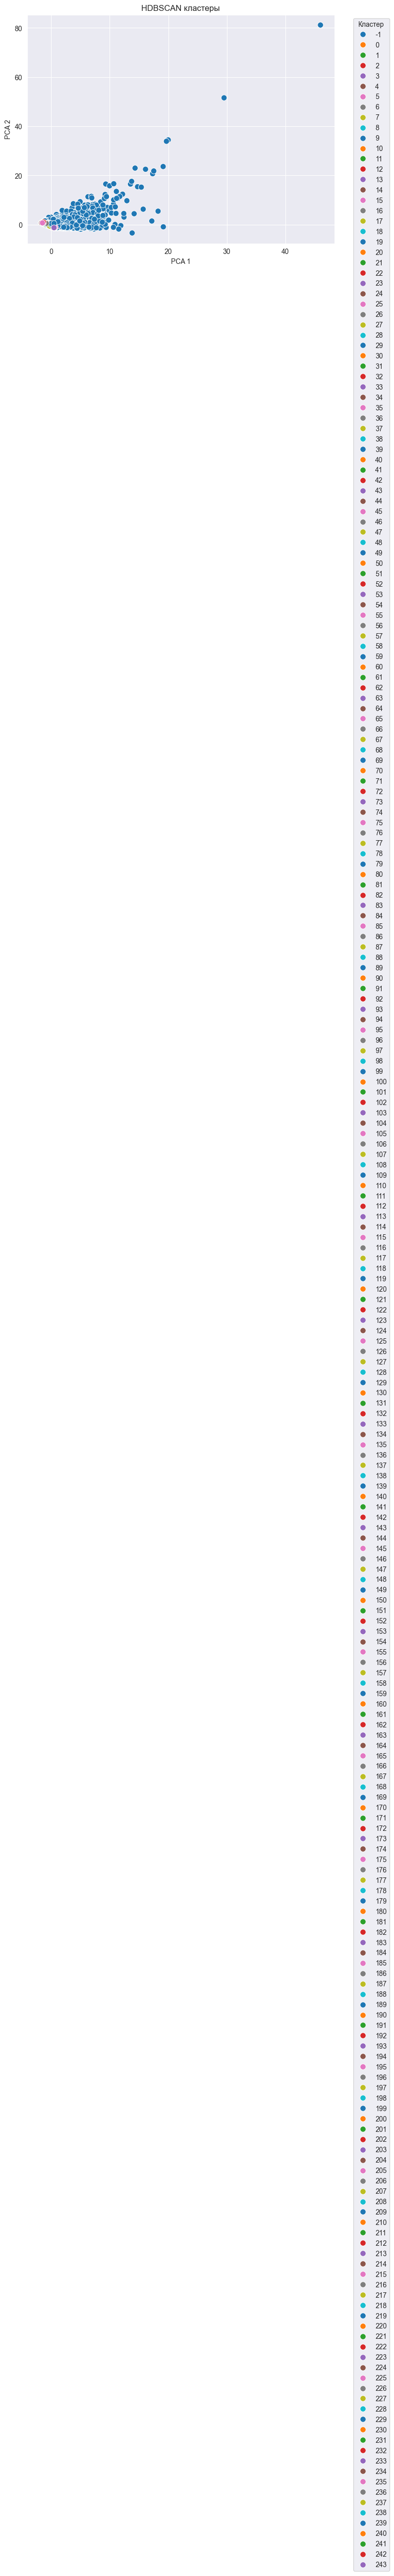

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

df_hdbscan_clusters['pca1'] = X_pca[:, 0]
df_hdbscan_clusters['pca2'] = X_pca[:, 1]

# Визуализация кластеров
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_hdbscan_clusters,
    x='pca1',
    y='pca2',
    hue='hdbscan_cluster',
    palette='tab10',
    s=70
)
plt.title("HDBSCAN кластеры")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Анализ кластеров

In [47]:
print(df_hdbscan_clusters['hdbscan_cluster'].value_counts())


hdbscan_cluster
-1      11698
 224      399
 61       367
 235      311
 100      249
        ...  
 108       30
 155       30
 36        30
 5         30
 38        30
Name: count, Length: 245, dtype: int64


#### Силуэт оценка HDBSCAN

In [48]:
from sklearn.metrics import silhouette_score

# Отфильтруем шум
mask_core = hdb_labels != -1
X_core = X_sampled[mask_core]
labels_core = hdb_labels[mask_core]

if len(set(labels_core)) >= 2:
    sil_score = silhouette_score(X_core, labels_core)
    print(f"Silhouette Score (HDBSCAN): {sil_score:.3f}")
else:
    print("Недостаточно кластеров (без учёта шума) для силуэт-оценки.")


Silhouette Score (HDBSCAN): 0.720
